
Trains a 100-Layer DenseNet on the CIFAR10 dataset.<br>
With data augmentation:<br>
Greater than 93.55% test accuracy in 200 epochs<br>
225sec per epoch on GTX 1080Ti<br>
Densely Connected Convolutional Networks<br>
https://arxiv.org/pdf/1608.06993.pdf<br>
http://openaccess.thecvf.com/content_cvpr_2017/papers/<br>
    Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf<br>
Network below is similar to 100-Layer DenseNet-BC (k=12)<br>


In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [23]:
from keras.layers import Dense, Conv2D, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Input, Flatten, Dropout
from keras.layers import concatenate, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import plot_model
from keras.utils import to_categorical
import os
import numpy as np
import math

training parameters

In [24]:
batch_size = 32
epochs = 200
data_augmentation = True

network parameters

In [25]:
num_classes = 10
num_dense_blocks = 3
use_max_pool = False

DenseNet-BC with dataset augmentation<br>
Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |<br>
12            | 100   |  95.49%          | 93.74%               |<br>
24            | 250   |  96.38%          | requires big mem GPU |<br>
40            | 190   |  96.54%          | requires big mem GPU |

In [26]:
growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

In [27]:
num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

load the CIFAR10 data

In [28]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input image dimensions

In [29]:
input_shape = x_train.shape[1:]

mormalize data

In [30]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


convert class vectors to binary class matrices.

In [31]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [32]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

start model definition<br>
densenet CNNs (composite function) are made of BN-ReLU-Conv2D

In [33]:
inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
x = concatenate([inputs, x])

stack of dense blocks bridged by transition layers

In [34]:
for i in range(num_dense_blocks):
    # a dense block is a stack of bottleneck layers
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    # no transition layer after the last dense block
    if i == num_dense_blocks - 1:
        continue

    # transition layer compresses num of feature maps and reduces the size by 2
    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=1,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)

add classifier on top<br>
after average pooling, size of feature map is 1 x 1

In [35]:
x = AveragePooling2D(pool_size=8)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='softmax')(y)

instantiate and compile model<br>
orig paper uses SGD but RMSprop works better for DenseNet

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization_99 (BatchN  (None, 32, 32, 3)   12          ['input_2[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activation_97 (Activation)     (None, 32, 32, 3)    0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 conv2d_99 (Conv2D)             (None, 32, 32, 24)   672         ['activation_97[0][0]']    

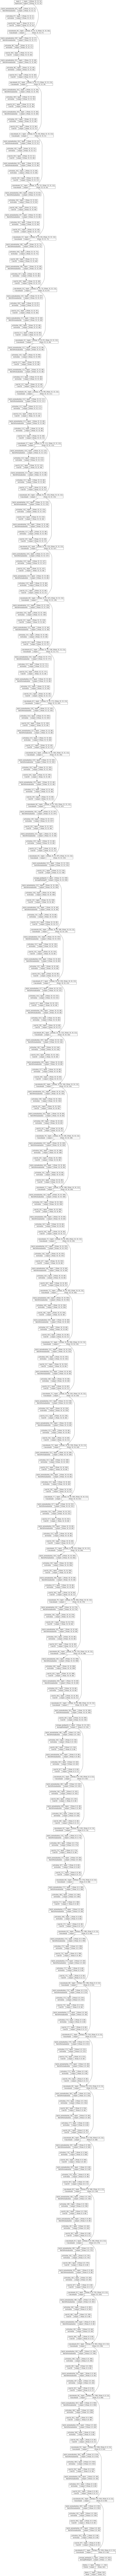

In [39]:
# Enable this when you have a Model saved already
from keras.models import load_model

# load existing model
model = load_model('./saved_models/cifar10_densenet_model.168.h5')

# Create a new model if it does not exist yet
# Comment these out when Model already exists
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy',
#               optimizer=RMSprop(1e-3),
#               metrics=['acc'])

# Print the Model Summary
model.summary()

# enable this if pydot can be installed
# pip install pydot
plot_model(model, to_file="cifar10-densenet.png", show_shapes=True)

prepare model model saving directory

In [40]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

prepare callbacks for model saving and for learning rate reducer

In [41]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [42]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [43]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [44]:
callbacks = [checkpoint, lr_reducer, lr_scheduler]

run training, with or without data augmentation

In [46]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    steps_per_epoch = math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=(epochs - 168) + 1,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/33
1563/1563 [==============================] - ETA: 0s - loss: 0.0588 - acc: 0.9827
Epoch 1: val_acc improved from -inf to 0.90510, saving model to /home/jupyter/Advanced-Deep-Learning-with-Keras/chapter2-deep-networks/saved_models/cifar10_densenet_model.01.h5
1563/1563 [==============================] - 182s 116ms/step - loss: 0.0588 - acc: 0.9827 - val_loss: 0.6766 - val_acc: 0.9051 - lr: 0.0010
Learning rate:  0.001
Epoch 2/33
1563/1563 [==============================] - ETA: 0s - loss: 0.0681 - acc: 0.9805
Epoch 2: val_acc improved from 0.90510 to 0.91570, saving model to /home/jupyter/Advanced-Deep-Learning-with-Keras/chapter2-deep-networks/saved_models/cifar10_densenet_model.02.h5
1563/1563 [==============================] - 178s 114ms/step - loss: 0.0681 - acc: 0.9805 - val_loss: 0.5475 - val_acc: 0.9157 - lr: 0.0010
Learning rate:  0.001
Epoch 3/33
1563/1563 [==============================] - ETA: 0s - loss: 0.06

In [47]:
    # fit the model on the batches generated by datagen.flow()
    #model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    ##                    steps_per_epoch=x_train.shape[0] // batch_size,
    #                    validation_data=(x_test, y_test),
    #                    epochs=epochs, verbose=1,
    #                    callbacks=callbacks)

score trained model

In [48]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.49799296259880066
Test accuracy: 0.9174000024795532
